In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

class SPYRegimeModel:
    """
    Advanced SPY options trading model with GBM simulation and regime identification
    Optimized for Jupyter notebook usage
    """
    
    def __init__(self):
        self.spy_data = None
        self.options_data = None
        self.regimes = None
        self.trading_signals = None
        self.adaptive_thresholds = {}
        
        # Model parameters - will be updated from historical data
        self.model_params = {
            'mu': 0.12,  # annual drift
            'sigma': 0.18,  # annual volatility
            'S0': 600,  # initial price
            'days': 252,  # trading days to simulate
            'dt': 1/252  # daily time step
        }
        
        # Regime parameters - MODIFY THESE FOR YOUR STRATEGY
        self.regime_params = {
            'lookback_period': 20,  # CHANGE TO 45 FOR YOUR STRATEGY
            'volatility_threshold': 0.25,
            'trend_threshold': 0.02,
            'regime_min_duration': 5,
            'threshold_estimation_period': 252,
            'use_adaptive_thresholds': True
        }
        
        # Risk-free rate (approximate current 3-month treasury)
        self.risk_free_rate = 0.045
    
    def fetch_spy_data(self, period='2y'):
        """Fetch SPY historical data using yfinance"""
        print("📊 Fetching SPY historical data...")
        spy = yf.Ticker("SPY")
        self.spy_data = spy.history(period=period)
        self.spy_data['returns'] = np.log(self.spy_data['Close'] / self.spy_data['Close'].shift(1))
        
        # Update model parameters based on historical data
        annual_return = self.spy_data['returns'].mean() * 252
        annual_vol = self.spy_data['returns'].std() * np.sqrt(252)
        current_price = self.spy_data['Close'].iloc[-1]
        
        self.model_params.update({
            'mu': annual_return,
            'sigma': annual_vol,
            'S0': current_price
        })
        
        print(f"✅ Data loaded: {len(self.spy_data)} trading days")
        print(f"📈 Historical annual return: {annual_return:.1%}")
        print(f"📉 Historical annual volatility: {annual_vol:.1%}")
        print(f"💰 Current SPY price: ${current_price:.2f}")
        
        return self.spy_data
    
    def fetch_options_data(self, expiration_days_ahead=45):
        """Fetch options data for IV calculation"""
        print("🎯 Fetching options data...")
        spy = yf.Ticker("SPY")
        
        try:
            # Get available expiration dates
            expirations = spy.options
            if not expirations:
                print("❌ No options data available")
                return None
            
            # Find expiration closest to desired DTE
            target_date = datetime.now() + timedelta(days=expiration_days_ahead)
            closest_exp = min(expirations, 
                             key=lambda x: abs((datetime.strptime(x, '%Y-%m-%d') - target_date).days))
            
            print(f"📅 Using expiration: {closest_exp}")
            
            # Get options chain
            opt_chain = spy.option_chain(closest_exp)
            
            # Combine calls and puts
            calls = opt_chain.calls.copy()
            puts = opt_chain.puts.copy()
            calls['type'] = 'call'
            puts['type'] = 'put'
            
            self.options_data = pd.concat([calls, puts], ignore_index=True)
            self.options_data['expiration'] = closest_exp
            self.options_data['days_to_exp'] = (datetime.strptime(closest_exp, '%Y-%m-%d') - datetime.now()).days
            
            print(f"✅ Options data loaded: {len(self.options_data)} contracts")
            
        except Exception as e:
            print(f"⚠️  Options data fetch failed: {e}")
            print("📝 Continuing with historical analysis only...")
            return None
        
        return self.options_data
    
    def black_scholes_price(self, S, K, T, r, sigma, option_type='call'):
        """Calculate Black-Scholes option price"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        if option_type == 'call':
            price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        else:
            price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
        
        return price
    
    def calculate_implied_volatility(self, market_price, S, K, T, r, option_type='call'):
        """Calculate implied volatility using Black-Scholes"""
        def objective(sigma):
            return abs(self.black_scholes_price(S, K, T, r, sigma, option_type) - market_price)
        
        try:
            result = minimize_scalar(objective, bounds=(0.01, 5.0), method='bounded')
            return result.x if result.success else np.nan
        except:
            return np.nan
    
    def calculate_current_iv_metrics(self):
        """Calculate current implied volatility and IV rank"""
        if self.options_data is None or self.spy_data is None:
            print("⚠️  Need both SPY and options data for IV analysis")
            return None, None
        
        current_price = self.spy_data['Close'].iloc[-1]
        
        # Calculate IV for each option
        iv_list = []
        
        print("🧮 Calculating implied volatilities...")
        
        for idx, row in self.options_data.iterrows():
            if row['volume'] > 0 and row['bid'] > 0 and row['ask'] > 0:
                market_price = (row['bid'] + row['ask']) / 2
                T = row['days_to_exp'] / 365
                
                iv = self.calculate_implied_volatility(
                    market_price, current_price, row['strike'], 
                    T, self.risk_free_rate, row['type']
                )
                
                if not np.isnan(iv) and 0.05 < iv < 2.0:  # Reasonable IV bounds
                    iv_list.append({
                        'strike': row['strike'],
                        'type': row['type'],
                        'iv': iv,
                        'delta': self.calculate_delta(current_price, row['strike'], T, self.risk_free_rate, iv, row['type']),
                        'volume': row['volume']
                    })
        
        if not iv_list:
            print("❌ No valid IV calculations")
            return None, None
        
        iv_df = pd.DataFrame(iv_list)
        
        # Calculate weighted average IV (volume-weighted)
        total_volume = iv_df['volume'].sum()
        if total_volume > 0:
            current_iv = (iv_df['iv'] * iv_df['volume']).sum() / total_volume
        else:
            current_iv = iv_df['iv'].mean()
        
        # Calculate IV rank using historical volatility
        hist_vol = self.spy_data['returns'].rolling(252).std() * np.sqrt(252)
        hist_vol_clean = hist_vol.dropna()
        
        if len(hist_vol_clean) > 20:
            iv_rank = (hist_vol_clean < current_iv).sum() / len(hist_vol_clean) * 100
        else:
            iv_rank = 50  # Default if insufficient data
        
        iv_metrics = {
            'current_iv': current_iv,
            'iv_rank': iv_rank,
            'atm_call_iv': iv_df[(iv_df['type'] == 'call') & (abs(iv_df['delta']) > 0.45)]['iv'].mean(),
            'atm_put_iv': iv_df[(iv_df['type'] == 'put') & (abs(iv_df['delta']) > 0.45)]['iv'].mean(),
            'iv_options_count': len(iv_df)
        }
        
        print(f"✅ Current IV: {current_iv:.1%}")
        print(f"📊 IV Rank: {iv_rank:.1f}%")
        
        return iv_metrics, iv_df
    
    def calculate_delta(self, S, K, T, r, sigma, option_type='call'):
        """Calculate option delta"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        
        if option_type == 'call':
            return norm.cdf(d1)
        else:
            return norm.cdf(d1) - 1
    
    def simulate_gbm(self, days=None, paths=1):
        """Simulate Geometric Brownian Motion paths"""
        if days is None:
            days = self.model_params['days']
        
        mu = self.model_params['mu']
        sigma = self.model_params['sigma']
        S0 = self.model_params['S0']
        dt = self.model_params['dt']
        
        # Generate random walks
        np.random.seed(42)  # For reproducibility
        dW = np.random.normal(0, np.sqrt(dt), (days, paths))
        
        # Initialize price array
        prices = np.zeros((days + 1, paths))
        prices[0] = S0
        
        # Simulate GBM
        for i in range(1, days + 1):
            dS = mu * prices[i-1] * dt + sigma * prices[i-1] * dW[i-1]
            prices[i] = np.maximum(0.01, prices[i-1] + dS)  # Prevent negative prices
        
        return prices
    
    def calculate_rolling_stats(self, prices, window):
        """Calculate rolling statistics for regime identification"""
        if isinstance(prices, np.ndarray):
            if len(prices.shape) > 1:
                prices = prices[:, 0]  # Take first path if multiple
            prices = pd.Series(prices)
        
        stats = []
        
        for i in range(window, len(prices)):
            window_prices = prices.iloc[i-window:i]
            returns = np.log(window_prices / window_prices.shift(1)).dropna()
            
            if len(returns) > 1:
                mean_return = returns.mean()
                volatility = returns.std() * np.sqrt(252)  # Annualized
                trend = mean_return * 252  # Annualized
                
                stats.append({
                    'day': i,
                    'price': prices.iloc[i],
                    'volatility': volatility,
                    'trend': trend,
                    'mean_return': mean_return
                })
        
        return pd.DataFrame(stats)
    
    def estimate_adaptive_thresholds(self, stats_df, estimation_period=252):
        """Estimate adaptive thresholds from historical data"""
        if len(stats_df) < 20:
            return {
                'volatility_threshold': 0.25,
                'trend_threshold': 0.02,
                'calculated': False,
                'reason': 'Insufficient data'
            }
        
        # Use the most recent data up to estimation_period
        data_to_analyze = stats_df.tail(min(estimation_period, len(stats_df)))
        
        volatilities = data_to_analyze['volatility'].values
        trends = np.abs(data_to_analyze['trend'].values)
        
        # Calculate percentiles
        vol_75th = np.percentile(volatilities, 75)
        trend_60th = np.percentile(trends, 60)
        
        # Calculate standard deviations for dynamic adjustment
        vol_mean = np.mean(volatilities)
        vol_std = np.std(volatilities)
        trend_mean = np.mean(trends)
        trend_std = np.std(trends)
        
        # Dynamic thresholds
        dynamic_vol_threshold = vol_mean + vol_std
        dynamic_trend_threshold = trend_mean + 0.5 * trend_std
        
        # Use the more conservative (higher) threshold
        volatility_threshold = max(vol_75th, dynamic_vol_threshold)
        trend_threshold = max(trend_60th, dynamic_trend_threshold)
        
        return {
            'volatility_threshold': round(volatility_threshold, 3),
            'trend_threshold': round(trend_threshold, 3),
            'calculated': True,
            'stats': {
                'vol_mean': round(vol_mean, 3),
                'vol_std': round(vol_std, 3),
                'vol_75th': round(vol_75th, 3),
                'trend_mean': round(trend_mean, 3),
                'trend_std': round(trend_std, 3),
                'trend_60th': round(trend_60th, 3),
                'data_points': len(data_to_analyze)
            }
        }
    
    def identify_regimes(self, stats_df, vol_threshold=None, trend_threshold=None):
        """Identify market regimes based on volatility and trend"""
        if vol_threshold is None:
            vol_threshold = (self.adaptive_thresholds.get('volatility_threshold', 
                           self.regime_params['volatility_threshold']))
        if trend_threshold is None:
            trend_threshold = (self.adaptive_thresholds.get('trend_threshold',
                             self.regime_params['trend_threshold']))
        
        regimes = []
        
        for idx, row in stats_df.iterrows():
            if row['volatility'] > vol_threshold:
                regime = 'High Volatility'
            elif row['trend'] > trend_threshold:
                regime = 'Trending Up'
            elif row['trend'] < -trend_threshold:
                regime = 'Trending Down'
            else:
                regime = 'Range Bound'
            
            regimes.append({
                'day': row['day'],
                'price': row['price'],
                'volatility': row['volatility'],
                'trend': row['trend'],
                'regime': regime
            })
        
        regime_df = pd.DataFrame(regimes)
        
        # Smooth regimes to avoid frequent switching
        min_duration = self.regime_params['regime_min_duration']
        smoothed_regimes = regime_df['regime'].copy()
        
        for i in range(min_duration, len(regime_df) - min_duration):
            window = regime_df['regime'].iloc[i-min_duration:i+min_duration+1]
            mode_regime = window.mode().iloc[0] if not window.mode().empty else window.iloc[0]
            smoothed_regimes.iloc[i] = mode_regime
        
        regime_df['regime'] = smoothed_regimes
        
        return regime_df
    
    def generate_trading_signals(self, regime_df):
        """Generate trading signals based on regime"""
        signals = []
        
        for idx, row in regime_df.iterrows():
            # Calculate confidence based on distance from thresholds
            vol_distance = abs(row['volatility'] - self.adaptive_thresholds.get('volatility_threshold', 0.25))
            trend_distance = abs(row['trend'] - self.adaptive_thresholds.get('trend_threshold', 0.02))
            
            if row['regime'] == 'Trending Up':
                signal = 'PUT_CREDIT_SPREAD'
                strategy = 'Sell Put Spreads (30Δ/10Δ, 45 DTE)'
                confidence = min(0.95, 0.65 + trend_distance * 15)
            elif row['regime'] == 'Trending Down':
                signal = 'CALL_CREDIT_SPREAD'
                strategy = 'Sell Call Spreads (30Δ/10Δ, 45 DTE)'
                confidence = min(0.95, 0.65 + trend_distance * 15)
            elif row['regime'] == 'Range Bound':
                signal = 'IRON_CONDOR'
                strategy = 'Iron Condors (16Δ wings, 45 DTE)'
                confidence = 0.75
            else:  # High Volatility
                signal = 'DEFENSIVE'
                strategy = 'Cash/Protective Strategies'
                confidence = min(0.9, 0.7 + vol_distance * 10)
            
            signals.append({
                'day': row['day'],
                'price': row['price'],
                'signal': signal,
                'strategy': strategy,
                'confidence': confidence,
                'regime': row['regime'],
                'volatility': row['volatility'],
                'trend': row['trend']
            })
        
        return pd.DataFrame(signals)
    
    def run_full_analysis(self, use_historical_data=True, simulation_days=252):
        """Run complete regime analysis"""
        print("🚀 STARTING SPY REGIME ANALYSIS")
        print("=" * 50)
        
        if use_historical_data:
            # Use actual SPY data
            self.fetch_spy_data()
            prices = self.spy_data['Close']
            print(f"📊 Using {len(prices)} days of historical data")
        else:
            # Use simulated data
            sim_prices = self.simulate_gbm(days=simulation_days)
            prices = pd.Series(sim_prices[:, 0])
            print(f"🎲 Using {simulation_days} days of simulated data")
        
        # Calculate rolling statistics
        print(f"\n🔢 Calculating rolling statistics (window: {self.regime_params['lookback_period']} days)...")
        stats_df = self.calculate_rolling_stats(prices, self.regime_params['lookback_period'])
        
        # Estimate adaptive thresholds
        if self.regime_params['use_adaptive_thresholds']:
            print("\n🎯 Estimating adaptive thresholds...")
            self.adaptive_thresholds = self.estimate_adaptive_thresholds(
                stats_df, self.regime_params['threshold_estimation_period']
            )
            print(f"📏 Volatility threshold: {self.adaptive_thresholds['volatility_threshold']}")
            print(f"📏 Trend threshold: {self.adaptive_thresholds['trend_threshold']}")
        
        # Identify regimes
        print("\n🏷️  Identifying market regimes...")
        self.regimes = self.identify_regimes(stats_df)
        
        # Generate trading signals
        print("📡 Generating trading signals...")
        self.trading_signals = self.generate_trading_signals(self.regimes)
        
        # Calculate regime statistics
        regime_stats = self.regimes['regime'].value_counts()
        regime_percentages = (regime_stats / len(self.regimes) * 100).round(1)
        
        print("\n" + "🎯 REGIME ANALYSIS RESULTS")
        print("="*40)
        
        for regime, percentage in regime_percentages.items():
            count = regime_stats[regime]
            emoji = {'Trending Up': '📈', 'Trending Down': '📉', 'Range Bound': '↔️', 'High Volatility': '⚡'}
            print(f"{emoji.get(regime, '📊')} {regime:.<20} {percentage:>5.1f}% ({count:>3} days)")
        
        # Current regime and signal
        if len(self.regimes) > 0:
            current_regime = self.regimes.iloc[-1]['regime']
            current_signal = self.trading_signals.iloc[-1]
            
            print(f"\n🎯 CURRENT STATUS:")
            print(f"💰 Price: ${current_signal['price']:.2f}")
            print(f"🏷️  Regime: {current_regime}")
            print(f"📋 Strategy: {current_signal['strategy']}")
            print(f"💪 Confidence: {current_signal['confidence']:.1%}")
        
        # Fetch and analyze options if using historical data
        if use_historical_data:
            try:
                print("\n" + "📊 IMPLIED VOLATILITY ANALYSIS")
                print("="*40)
                
                self.fetch_options_data()
                if self.options_data is not None:
                    iv_metrics, iv_df = self.calculate_current_iv_metrics()
                    if iv_metrics:
                        print(f"📈 Current IV: {iv_metrics['current_iv']:.1%}")
                        print(f"📊 IV Rank: {iv_metrics['iv_rank']:.1f}%")
                        if not np.isnan(iv_metrics.get('atm_call_iv', np.nan)):
                            print(f"📞 ATM Call IV: {iv_metrics.get('atm_call_iv', 0):.1%}")
                        if not np.isnan(iv_metrics.get('atm_put_iv', np.nan)):
                            print(f"📱 ATM Put IV: {iv_metrics.get('atm_put_iv', 0):.1%}")
                        
                        # IV rank interpretation
                        iv_rank = iv_metrics['iv_rank']
                        if iv_rank < 20:
                            print("💡 IV Assessment: LOW - Favor premium selling strategies")
                        elif iv_rank < 50:
                            print("💡 IV Assessment: MODERATE - Standard strategies work well")
                        elif iv_rank < 80:
                            print("💡 IV Assessment: ELEVATED - Be selective with entries")
                        else:
                            print("💡 IV Assessment: HIGH - Consider premium buying or defensive strategies")
                            
            except Exception as e:
                print(f"⚠️  Options analysis error: {e}")
        
        print("\n✅ Analysis complete!")
        return self.regimes, self.trading_signals
    
    def plot_regime_analysis(self, figsize=(16, 12)):
        """Create comprehensive visualization of regime analysis"""
        if self.regimes is None:
            print("❌ Run analysis first")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('📊 SPY Regime Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # Color mapping for regimes
        regime_colors = {
            'Trending Up': '#22c55e',
            'Trending Down': '#ef4444',
            'Range Bound': '#3b82f6',
            'High Volatility': '#f59e0b'
        }
        
        # 1. Price chart with regime overlay
        ax1 = axes[0, 0]
        ax1.plot(self.regimes['day'], self.regimes['price'], 'k-', alpha=0.7, linewidth=1)
        
        for regime in regime_colors.keys():
            regime_data = self.regimes[self.regimes['regime'] == regime]
            if not regime_data.empty:
                ax1.scatter(regime_data['day'], regime_data['price'], 
                           c=regime_colors[regime], label=regime, alpha=0.6, s=20)
        
        ax1.set_title('📈 Price with Regime Classification')
        ax1.set_xlabel('Trading Day')
        ax1.set_ylabel('SPY Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Regime distribution
        ax2 = axes[0, 1]
        regime_counts = self.regimes['regime'].value_counts()
        colors = [regime_colors[regime] for regime in regime_counts.index]
        
        wedges, texts, autotexts = ax2.pie(regime_counts.values, labels=regime_counts.index, 
                                          autopct='%1.1f%%', colors=colors, startangle=90)
        ax2.set_title('🥧 Regime Distribution')
        
        # 3. Volatility vs Trend scatter
        ax3 = axes[1, 0]
        for regime in regime_colors.keys():
            regime_data = self.regimes[self.regimes['regime'] == regime]
            if not regime_data.empty:
                ax3.scatter(regime_data['trend'], regime_data['volatility'], 
                           c=regime_colors[regime], label=regime, alpha=0.6)
        
        # Add threshold lines
        if self.adaptive_thresholds.get('calculated', False):
            vol_thresh = self.adaptive_thresholds['volatility_threshold']
            trend_thresh = self.adaptive_thresholds['trend_threshold']
        else:
            vol_thresh = self.regime_params['volatility_threshold']
            trend_thresh = self.regime_params['trend_threshold']
        
        ax3.axhline(y=vol_thresh, color='red', linestyle='--', alpha=0.7, label=f'Vol Threshold ({vol_thresh})')
        ax3.axvline(x=trend_thresh, color='blue', linestyle='--', alpha=0.7, label=f'Trend Threshold ({trend_thresh})')
        ax3.axvline(x=-trend_thresh, color='blue', linestyle='--', alpha=0.7)
        
        ax3.set_xlabel('Annualized Trend')
        ax3.set_ylabel('Annualized Volatility')
        ax3.set_title('🎯 Regime Classification Space')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Trading signals confidence
        ax4 = axes[1, 1]
        signal_summary = self.trading_signals.groupby('signal')['confidence'].agg(['mean', 'count'])
        
        x_pos = np.arange(len(signal_summary))
        bars = ax4.bar(x_pos, signal_summary['mean'], alpha=0.7)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, signal_summary['count'])):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
        
        ax4.set_xlabel('Trading Signal')
        ax4.set_ylabel('Average Confidence')
        ax4.set_title('📊 Trading Signal Confidence')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(signal_summary.index, rotation=45, ha='right')
        ax4.set_ylim(0, 1)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def get_current_recommendation(self):
        """Get current trading recommendation"""
        if self.trading_signals is None or len(self.trading_signals) == 0:
            return "❌ Run analysis first"
        
        current = self.trading_signals.iloc[-1]
        
        recommendation = f"""
🎯 CURRENT TRADING RECOMMENDATION
{'='*50}
🏷️  Regime: {current['regime']}
📋 Strategy: {current['strategy']}
💪 Confidence: {current['confidence']:.1%}

📊 Market Conditions:
💰 Price: ${current['price']:.2f}
📉 Volatility: {current['volatility']:.1%}
📈 Trend: {current['trend']:.1%}

⚠️  Risk Management:
🎯 Position size: Max 5% account risk per trade
💰 Profit target: 50% of max profit
🛑 Stop loss: 25% of premium collected
⏰ Close at 21 DTE to avoid gamma risk
        """
        
        return recommendation
    
    def analyze_threshold_sensitivity(self):
        """Analyze how different thresholds affect regime classification"""
        if self.spy_data is None:
            print("❌ Fetch SPY data first")
            return
        
        print("🔍 THRESHOLD SENSITIVITY ANALYSIS")
        print("="*50)
        
        prices = self.spy_data['Close']
        stats_df = self.calculate_rolling_stats(prices, self.regime_params['lookback_period'])
        
        vol_thresholds = [0.15, 0.20, 0.25, 0.30, 0.35]
        trend_thresholds = [0.01, 0.015, 0.02, 0.025, 0.03]
        
        results = []
        
        for vol_thresh in vol_thresholds:
            for trend_thresh in trend_thresholds:
                regimes = self.identify_regimes(stats_df, vol_thresh, trend_thresh)
                regime_dist = regimes['regime'].value_counts(normalize=True)
                
                # Count regime changes
                changes = sum(1 for i in range(1, len(regimes)) 
                             if regimes.iloc[i]['regime'] != regimes.iloc[i-1]['regime'])
                
                results.append({
                    'vol_threshold': vol_thresh,
                    'trend_threshold': trend_thresh,
                    'trending_up_pct': regime_dist.get('Trending Up', 0) * 100,
                    'trending_down_pct': regime_dist.get('Trending Down', 0) * 100,
                    'range_bound_pct': regime_dist.get('Range Bound', 0) * 100,
                    'high_vol_pct': regime_dist.get('High Volatility', 0) * 100,
                    'regime_changes': changes
                })
        
        results_df = pd.DataFrame(results)
        
        # Display optimal thresholds
        print("\n📊 THRESHOLD SENSITIVITY RESULTS:")
        print("Vol\tTrend\tUp%\tDown%\tRange%\tHighVol%\tChanges")
        print("-" * 60)
        
        for _, row in results_df.iterrows():
            print(f"{row['vol_threshold']:.2f}\t{row['trend_threshold']:.3f}\t"
                  f"{row['trending_up_pct']:.0f}\t{row['trending_down_pct']:.0f}\t"
                  f"{row['range_bound_pct']:.0f}\t{row['high_vol_pct']:.0f}\t\t"
                  f"{row['regime_changes']}")
        
        # Recommend optimal thresholds (balanced regime distribution, moderate changes)
        optimal = results_df.loc[
            (results_df['regime_changes'] > results_df['regime_changes'].quantile(0.3)) &
            (results_df['regime_changes'] < results_df['regime_changes'].quantile(0.7))
        ].iloc[0]
        
        print(f"\n💡 RECOMMENDED THRESHOLDS:")
        print(f"Volatility: {optimal['vol_threshold']:.3f}")
        print(f"Trend: {optimal['trend_threshold']:.3f}")
        print(f"(Balanced regime distribution with {optimal['regime_changes']:.0f} regime changes)")
        
        return results_df


# =============================================================================
# HELPER FUNCTIONS FOR ANALYSIS
# =============================================================================

def compare_threshold_methods():
    """Compare fixed vs adaptive thresholds"""
    
    model = SPYRegimeModel()
    model.fetch_spy_data()
    
    prices = model.spy_data['Close']
    stats_df = model.calculate_rolling_stats(prices, 20)
    
    # Fixed thresholds
    model.regime_params['use_adaptive_thresholds'] = False
    regimes_fixed = model.identify_regimes(stats_df)
    
    # Adaptive thresholds
    model.regime_params['use_adaptive_thresholds'] = True
    model.adaptive_thresholds = model.estimate_adaptive_thresholds(stats_df)
    regimes_adaptive = model.identify_regimes(stats_df)
    
    # Compare distributions
    print("🔍 THRESHOLD COMPARISON")
    print("="*40)
    print("\n📊 Fixed Thresholds (0.25 vol, 0.02 trend):")
    fixed_dist = regimes_fixed['regime'].value_counts(normalize=True).round(3)
    for regime, pct in fixed_dist.items():
        print(f"  {regime}: {pct:.1%}")
    
    print(f"\n🎯 Adaptive Thresholds:")
    print(f"  Volatility: {model.adaptive_thresholds['volatility_threshold']}")
    print(f"  Trend: {model.adaptive_thresholds['trend_threshold']}")
    adaptive_dist = regimes_adaptive['regime'].value_counts(normalize=True).round(3)
    for regime, pct in adaptive_dist.items():
        print(f"  {regime}: {pct:.1%}")
    
    return regimes_fixed, regimes_adaptive


def run_dte_analysis(lookback_period=45):
    """Run analysis for specific DTE strategies with configurable lookback period"""
    
    print(f"🎯 {lookback_period} DTE STRATEGY ANALYSIS")
    print("="*40)
    
    model = SPYRegimeModel()
    
    # Configure for specified DTE strategies
    model.regime_params['lookback_period'] = lookback_period
    model.regime_params['threshold_estimation_period'] = max(500, lookback_period * 10)  # Scale with DTE
    
    print(f"📊 Configured for {lookback_period} day lookback period")
    print(f"📈 Using {model.regime_params['threshold_estimation_period']} days for threshold estimation")
    
    # Run analysis
    regimes, signals = model.run_full_analysis(use_historical_data=True)
    
    # Get current recommendation
    print(model.get_current_recommendation())
    
    # Plot results
    model.plot_regime_analysis()
    
    return model


def stress_test_market_conditions():
    """Test model under different market scenarios"""
    
    scenarios = [
        {'name': 'Bull Market', 'mu': 0.15, 'sigma': 0.16},
        {'name': 'Bear Market', 'mu': -0.20, 'sigma': 0.35},
        {'name': 'Sideways Market', 'mu': 0.02, 'sigma': 0.12},
        {'name': 'High Volatility', 'mu': 0.08, 'sigma': 0.45}
    ]
    
    results = {}
    
    for scenario in scenarios:
        print(f"\n🧪 Testing {scenario['name']}...")
        
        model = SPYRegimeModel()
        model.model_params['mu'] = scenario['mu']
        model.model_params['sigma'] = scenario['sigma']
        
        regimes, signals = model.run_full_analysis(use_historical_data=False, simulation_days=252)
        
        # Analyze regime distribution
        regime_dist = regimes['regime'].value_counts(normalize=True)
        signal_dist = signals['signal'].value_counts(normalize=True)
        avg_confidence = signals['confidence'].mean()
        
        results[scenario['name']] = {
            'regime_distribution': regime_dist,
            'signal_distribution': signal_dist,
            'avg_confidence': avg_confidence
        }
        
        print(f"  Primary regime: {regime_dist.index[0]} ({regime_dist.iloc[0]:.1%})")
        print(f"  Primary signal: {signal_dist.index[0]} ({signal_dist.iloc[0]:.1%})")
        print(f"  Avg confidence: {avg_confidence:.1%}")
    
    return results

In [3]:
# Test the complete class
model = SPYRegimeModel()
regimes, signals = model.run_full_analysis(use_historical_data=True)

🚀 STARTING SPY REGIME ANALYSIS
📊 Fetching SPY historical data...
✅ Data loaded: 503 trading days
📈 Historical annual return: 18.2%
📉 Historical annual volatility: 16.4%
💰 Current SPY price: $637.03
📊 Using 503 days of historical data

🔢 Calculating rolling statistics (window: 20 days)...

🎯 Estimating adaptive thresholds...
📏 Volatility threshold: 0.283
📏 Trend threshold: 0.657

🏷️  Identifying market regimes...
📡 Generating trading signals...

🎯 REGIME ANALYSIS RESULTS
↔️ Range Bound.........  83.9% (405 days)
📈 Trending Up.........   7.7% ( 37 days)
⚡ High Volatility.....   5.0% ( 24 days)
📉 Trending Down.......   3.5% ( 17 days)

🎯 CURRENT STATUS:
💰 Price: $637.03
🏷️  Regime: Range Bound
📋 Strategy: Iron Condors (16Δ wings, 45 DTE)
💪 Confidence: 75.0%

📊 IMPLIED VOLATILITY ANALYSIS
🎯 Fetching options data...
📅 Using expiration: 2025-09-19
✅ Options data loaded: 261 contracts
🧮 Calculating implied volatilities...
✅ Current IV: 21.6%
📊 IV Rank: 100.0%
📈 Current IV: 21.6%
📊 IV Rank: 10

In [4]:
# See difference between fixed and adaptive thresholds
regimes_fixed, regimes_adaptive = compare_threshold_methods()

📊 Fetching SPY historical data...
✅ Data loaded: 503 trading days
📈 Historical annual return: 18.2%
📉 Historical annual volatility: 16.4%
💰 Current SPY price: $637.06
🔍 THRESHOLD COMPARISON

📊 Fixed Thresholds (0.25 vol, 0.02 trend):
  Trending Up: 68.3%
  Trending Down: 25.5%
  High Volatility: 5.0%
  Range Bound: 1.2%

🎯 Adaptive Thresholds:
  Volatility: 0.283
  Trend: 0.657
  Range Bound: 83.9%
  Trending Up: 7.7%
  High Volatility: 5.0%
  Trending Down: 3.5%


🎯 45 DTE STRATEGY ANALYSIS
📊 Configured for 45 day lookback period
📈 Using 500 days for threshold estimation
🚀 STARTING SPY REGIME ANALYSIS
📊 Fetching SPY historical data...
✅ Data loaded: 503 trading days
📈 Historical annual return: 18.2%
📉 Historical annual volatility: 16.4%
💰 Current SPY price: $637.10
📊 Using 503 days of historical data

🔢 Calculating rolling statistics (window: 45 days)...

🎯 Estimating adaptive thresholds...
📏 Volatility threshold: 0.227
📏 Trend threshold: 0.425

🏷️  Identifying market regimes...
📡 Generating trading signals...

🎯 REGIME ANALYSIS RESULTS
↔️ Range Bound.........  65.3% (299 days)
📈 Trending Up.........  24.2% (111 days)
⚡ High Volatility.....  10.5% ( 48 days)

🎯 CURRENT STATUS:
💰 Price: $637.10
🏷️  Regime: Range Bound
📋 Strategy: Iron Condors (16Δ wings, 45 DTE)
💪 Confidence: 75.0%

📊 IMPLIED VOLATILITY ANALYSIS
🎯 Fetching options data...
📅 Using expiration: 2025-09-19
✅ Options data loaded: 261 contracts
🧮 Calculating implied volatilities...
✅ C

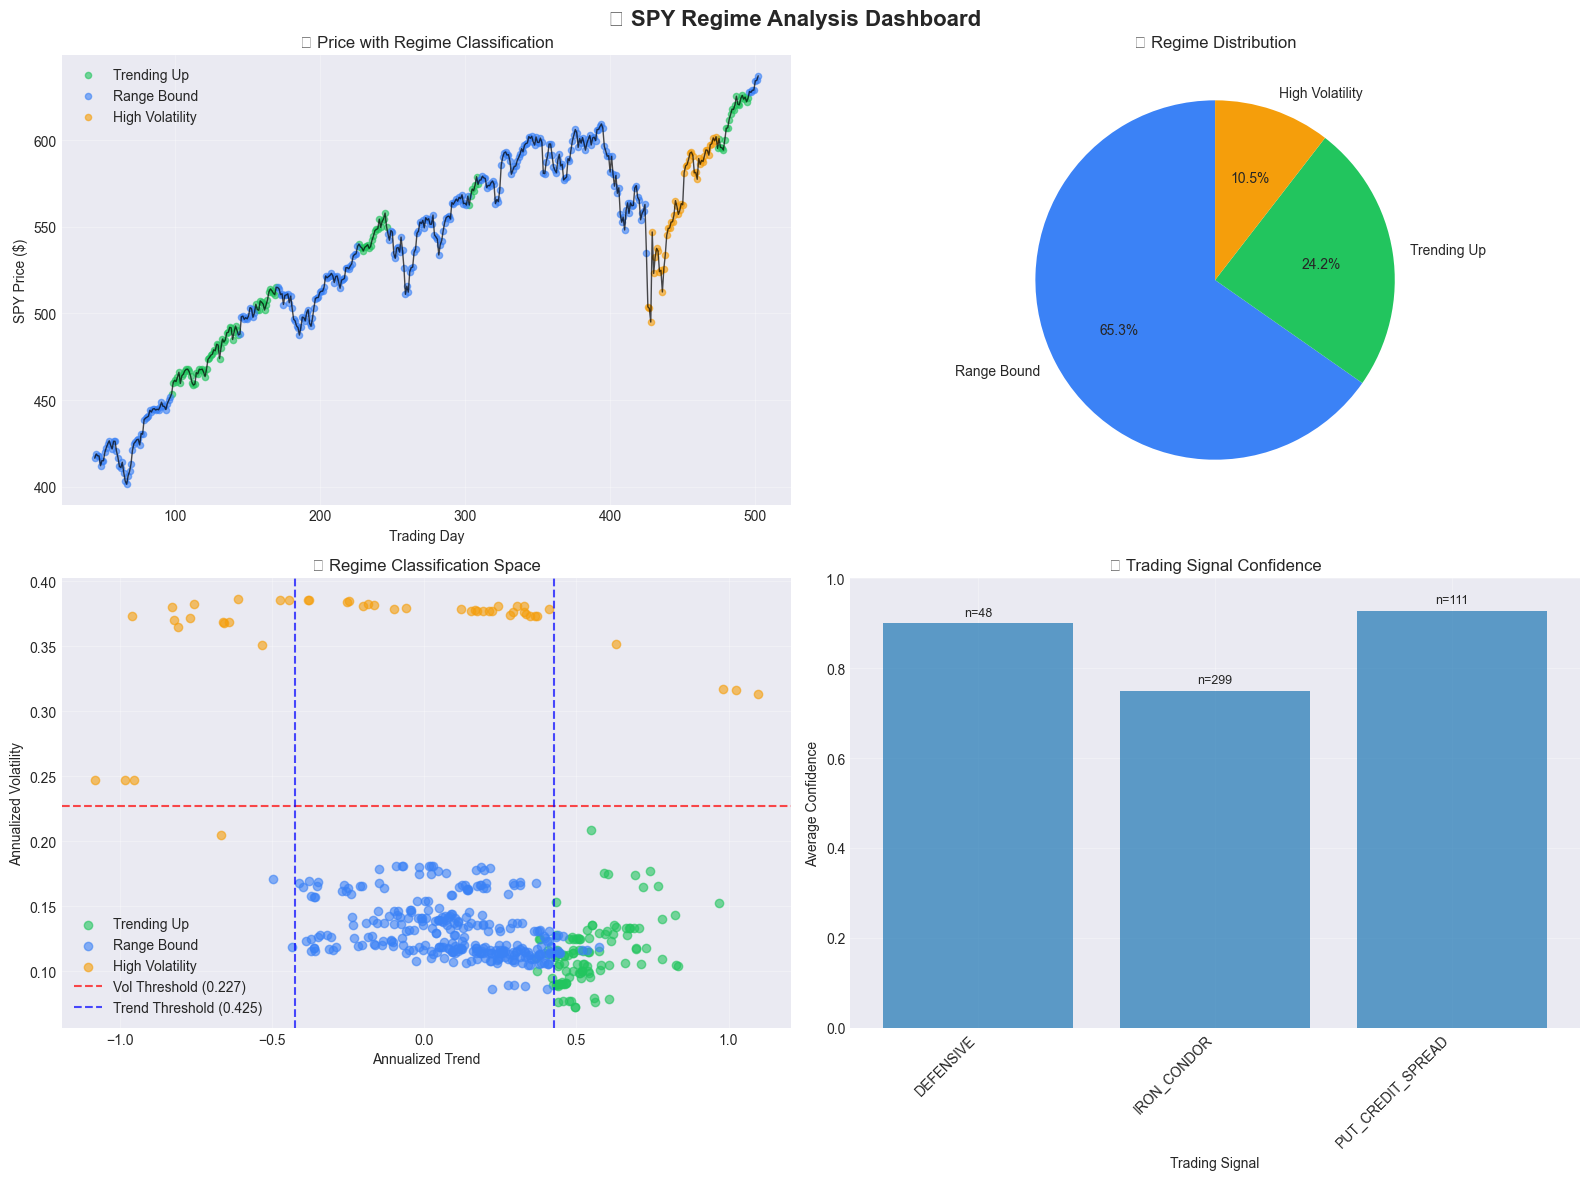

🎯 20 DTE STRATEGY ANALYSIS
📊 Configured for 20 day lookback period
📈 Using 500 days for threshold estimation
🚀 STARTING SPY REGIME ANALYSIS
📊 Fetching SPY historical data...
✅ Data loaded: 503 trading days
📈 Historical annual return: 18.2%
📉 Historical annual volatility: 16.4%
💰 Current SPY price: $637.10
📊 Using 503 days of historical data

🔢 Calculating rolling statistics (window: 20 days)...

🎯 Estimating adaptive thresholds...
📏 Volatility threshold: 0.23
📏 Trend threshold: 0.603

🏷️  Identifying market regimes...
📡 Generating trading signals...

🎯 REGIME ANALYSIS RESULTS
↔️ Range Bound.........  80.3% (388 days)
📈 Trending Up.........   9.5% ( 46 days)
⚡ High Volatility.....   5.2% ( 25 days)
📉 Trending Down.......   5.0% ( 24 days)

🎯 CURRENT STATUS:
💰 Price: $637.10
🏷️  Regime: Range Bound
📋 Strategy: Iron Condors (16Δ wings, 45 DTE)
💪 Confidence: 75.0%

📊 IMPLIED VOLATILITY ANALYSIS
🎯 Fetching options data...
📅 Using expiration: 2025-09-19
✅ Options data loaded: 261 contracts
🧮

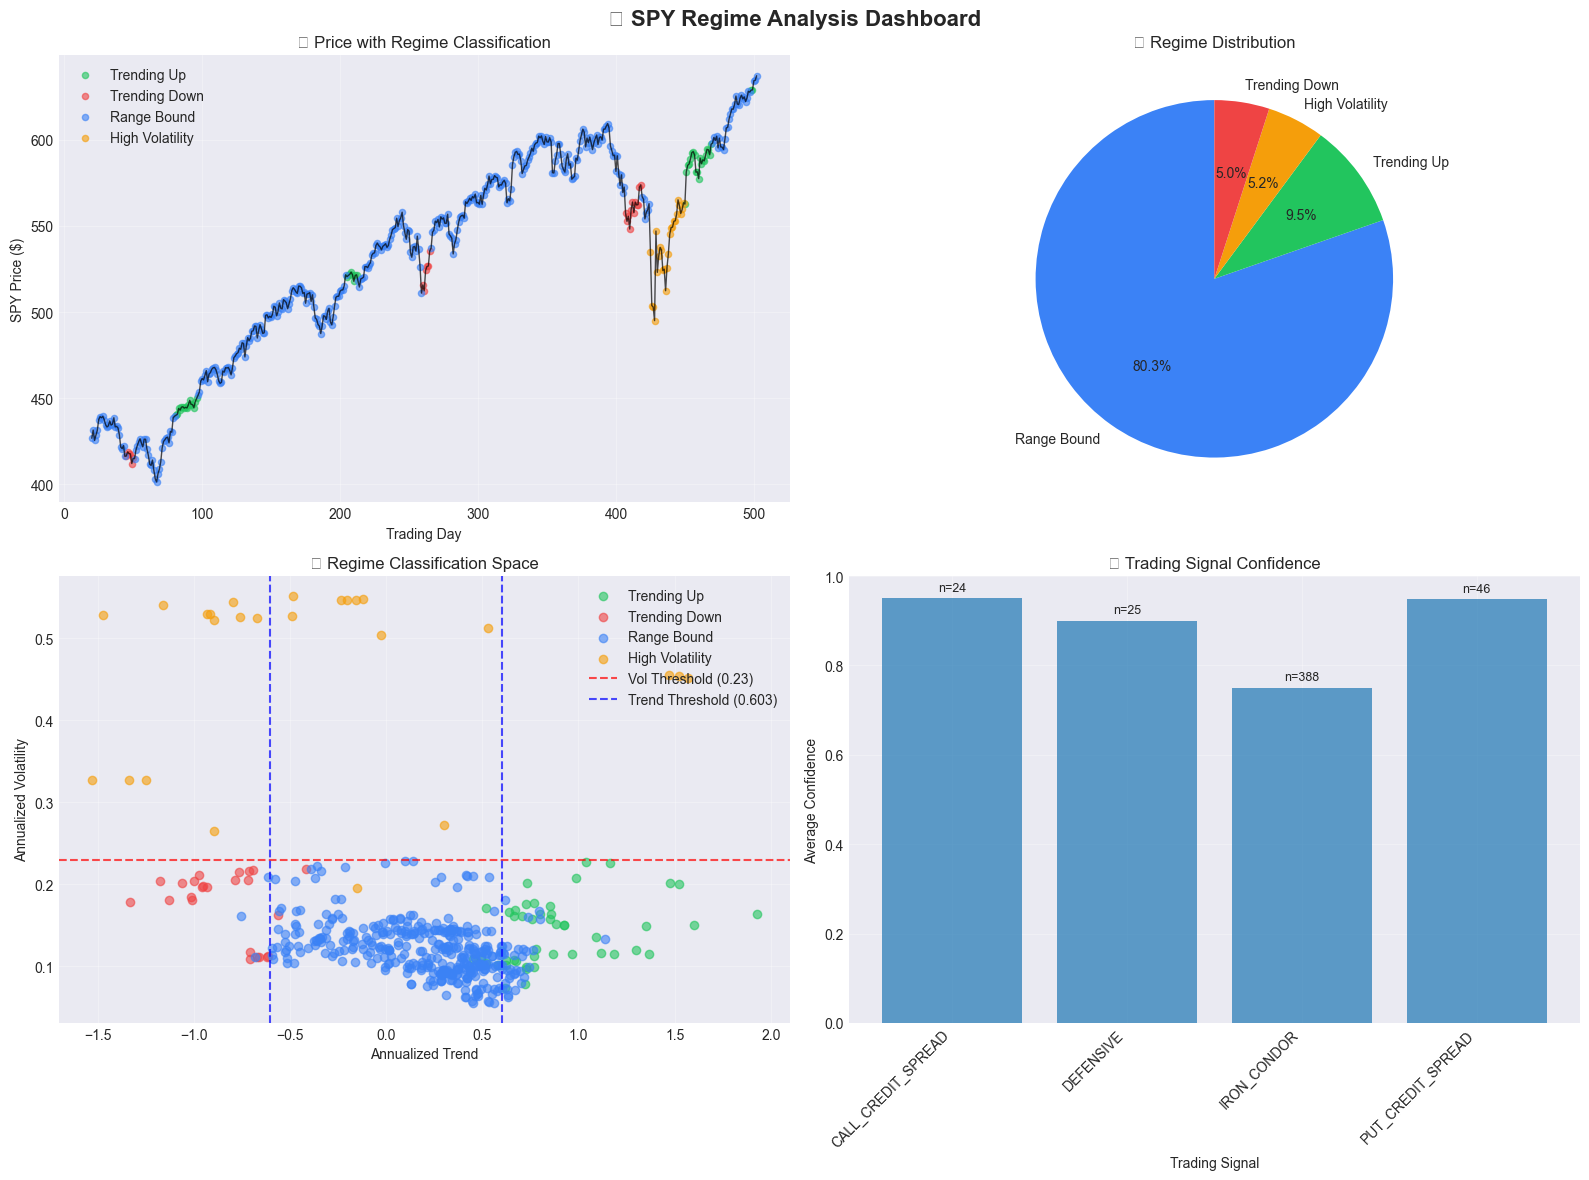

🎯 60 DTE STRATEGY ANALYSIS
📊 Configured for 60 day lookback period
📈 Using 600 days for threshold estimation
🚀 STARTING SPY REGIME ANALYSIS
📊 Fetching SPY historical data...
✅ Data loaded: 503 trading days
📈 Historical annual return: 18.2%
📉 Historical annual volatility: 16.4%
💰 Current SPY price: $637.10
📊 Using 503 days of historical data

🔢 Calculating rolling statistics (window: 60 days)...

🎯 Estimating adaptive thresholds...
📏 Volatility threshold: 0.226
📏 Trend threshold: 0.372

🏷️  Identifying market regimes...
📡 Generating trading signals...

🎯 REGIME ANALYSIS RESULTS
↔️ Range Bound.........  61.2% (271 days)
📈 Trending Up.........  24.8% (110 days)
⚡ High Volatility.....  14.0% ( 62 days)

🎯 CURRENT STATUS:
💰 Price: $637.10
🏷️  Regime: Trending Up
📋 Strategy: Sell Put Spreads (30Δ/10Δ, 45 DTE)
💪 Confidence: 95.0%

📊 IMPLIED VOLATILITY ANALYSIS
🎯 Fetching options data...
📅 Using expiration: 2025-09-19
✅ Options data loaded: 261 contracts
🧮 Calculating implied volatilities...
✅

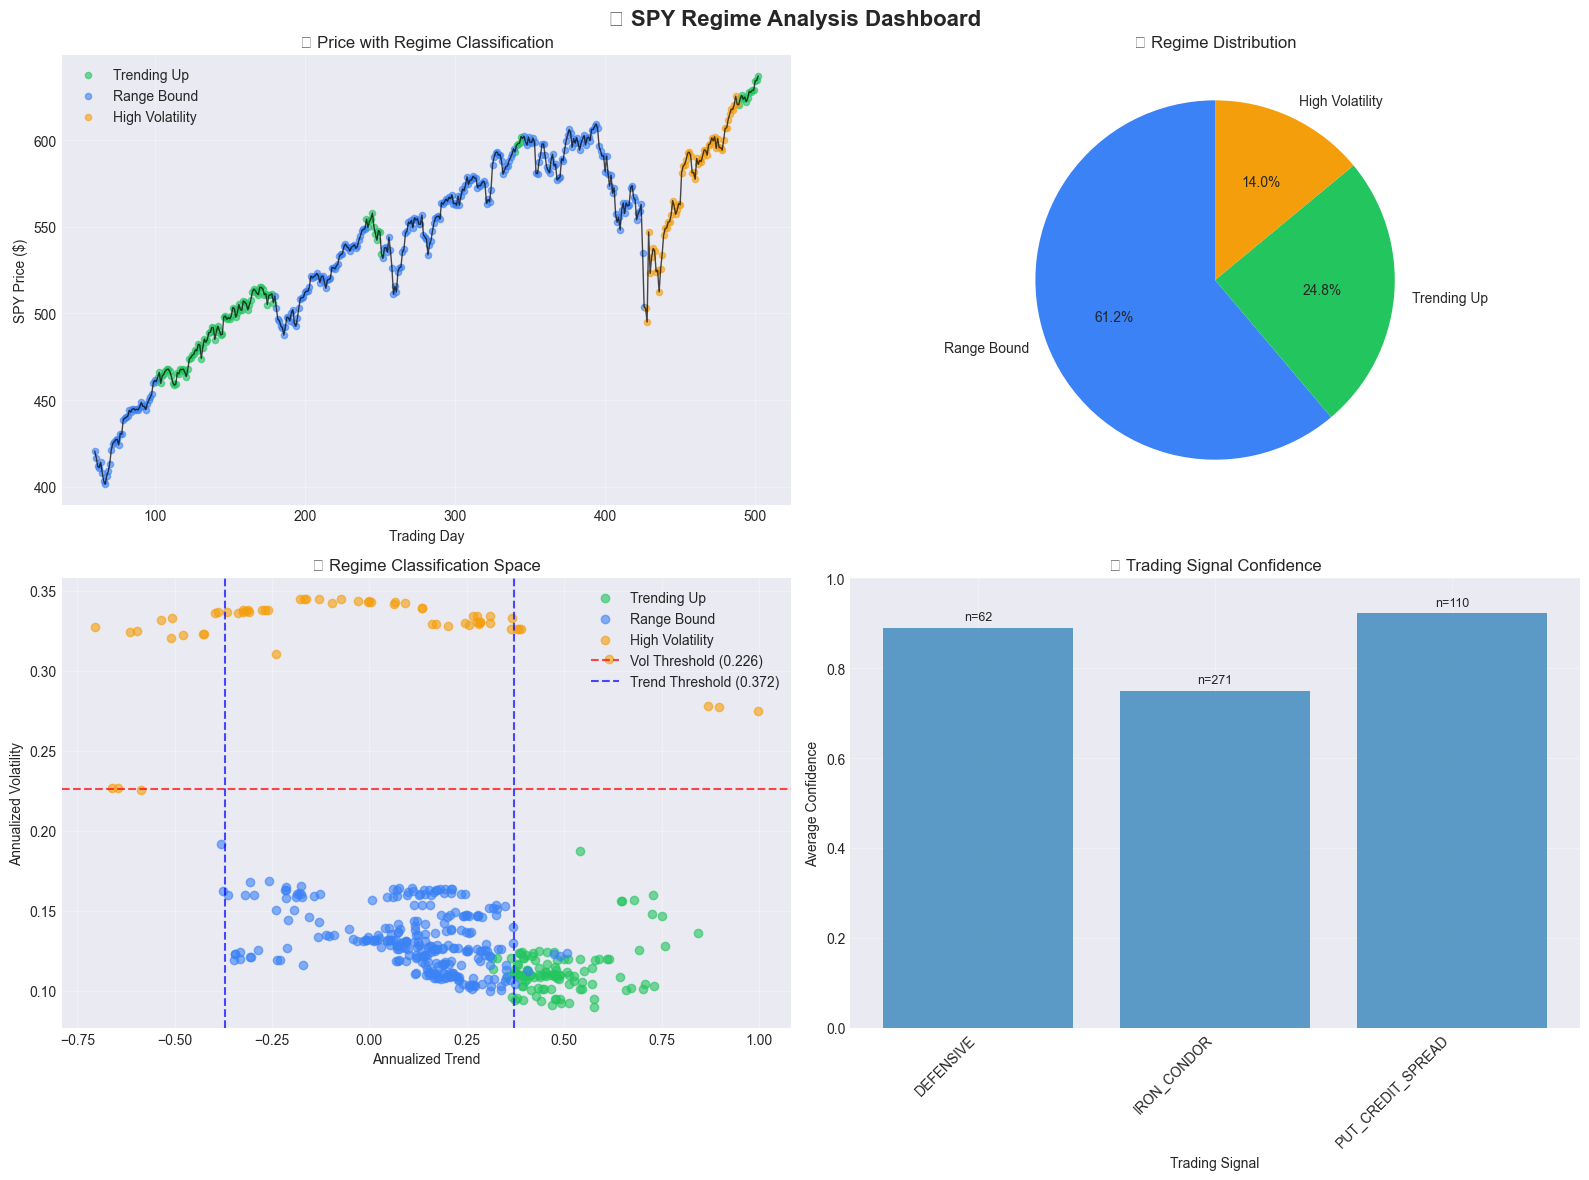

🎯 7 DTE STRATEGY ANALYSIS
📊 Configured for 7 day lookback period
📈 Using 500 days for threshold estimation
🚀 STARTING SPY REGIME ANALYSIS
📊 Fetching SPY historical data...
✅ Data loaded: 503 trading days
📈 Historical annual return: 18.2%
📉 Historical annual volatility: 16.4%
💰 Current SPY price: $637.10
📊 Using 503 days of historical data

🔢 Calculating rolling statistics (window: 7 days)...

🎯 Estimating adaptive thresholds...
📏 Volatility threshold: 0.234
📏 Trend threshold: 1.078

🏷️  Identifying market regimes...
📡 Generating trading signals...

🎯 REGIME ANALYSIS RESULTS
↔️ Range Bound.........  86.1% (427 days)
⚡ High Volatility.....   6.0% ( 30 days)
📈 Trending Up.........   4.4% ( 22 days)
📉 Trending Down.......   3.4% ( 17 days)

🎯 CURRENT STATUS:
💰 Price: $637.10
🏷️  Regime: Range Bound
📋 Strategy: Iron Condors (16Δ wings, 45 DTE)
💪 Confidence: 75.0%

📊 IMPLIED VOLATILITY ANALYSIS
🎯 Fetching options data...
📅 Using expiration: 2025-09-19
✅ Options data loaded: 261 contracts
🧮 C

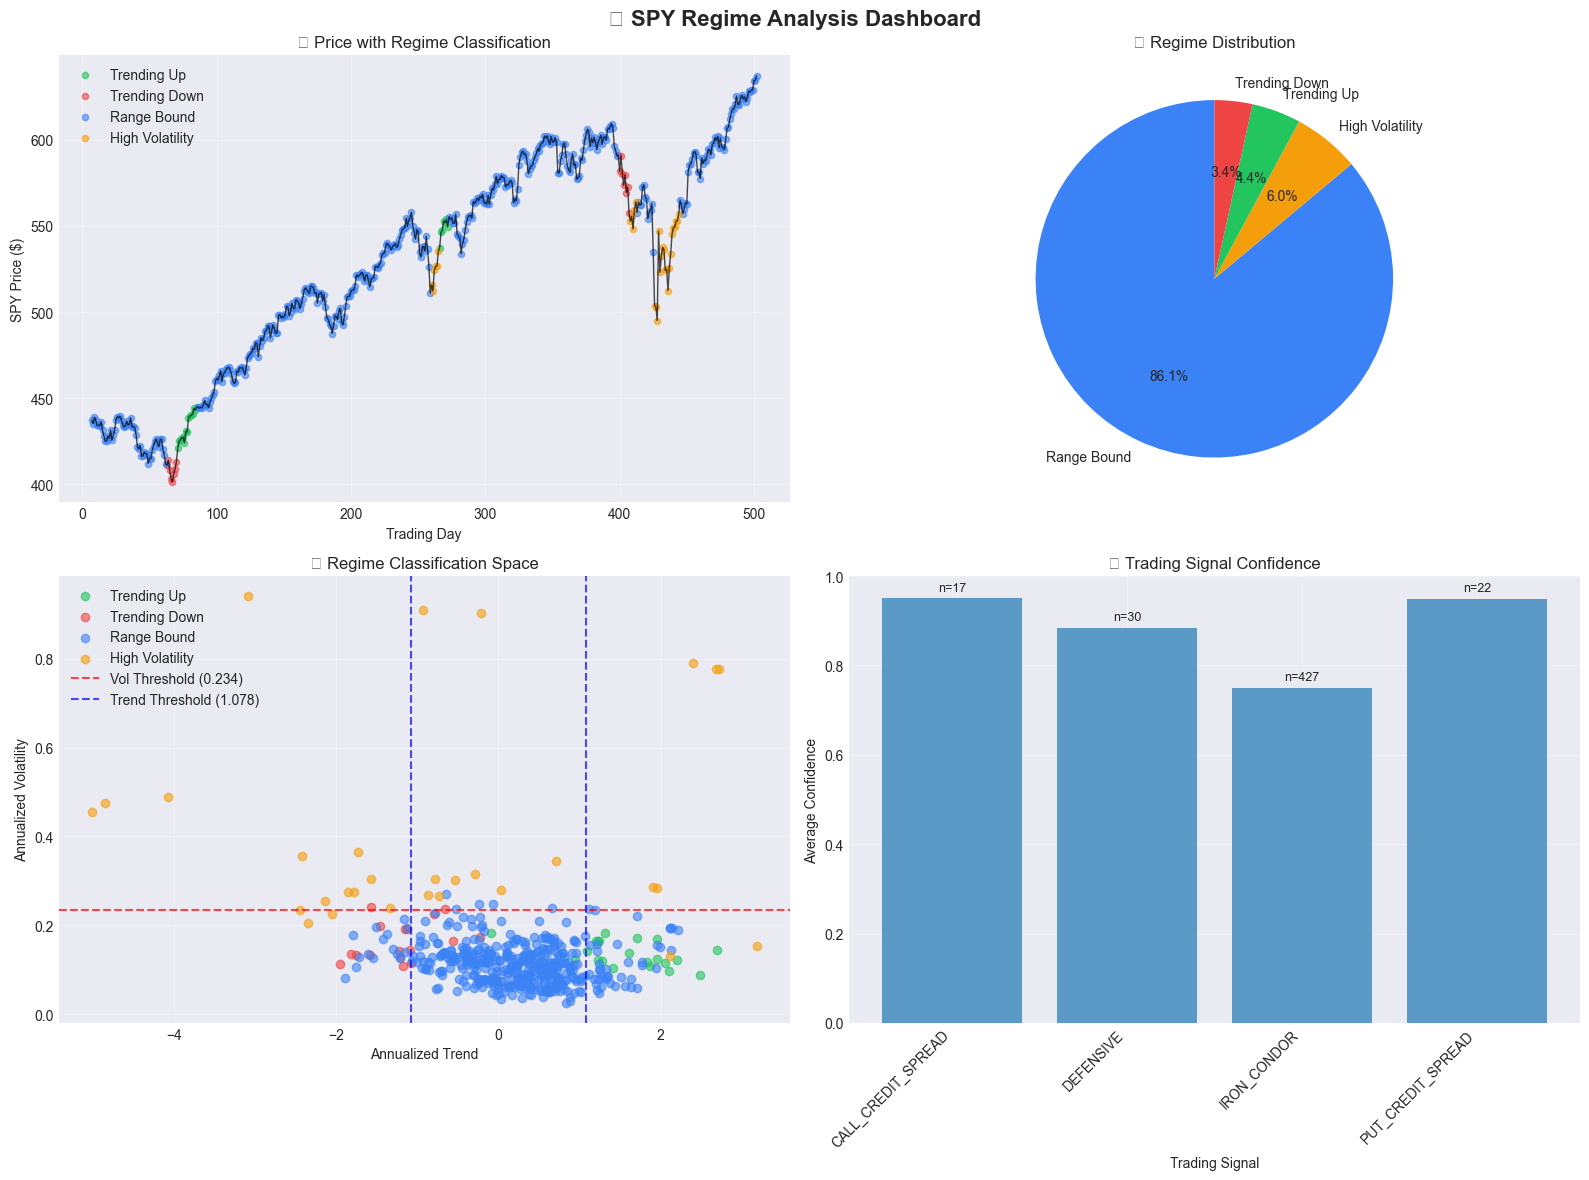

In [5]:
# Your standard 45 DTE analysis
model = run_dte_analysis()  # Uses default 45

# Test shorter-term strategies
model = run_dte_analysis(lookback_period=20)  # 20 DTE

# Test longer-term strategies  
model = run_dte_analysis(lookback_period=60)  # 60 DTE

# Very short-term
model = run_dte_analysis(lookback_period=7)   # Weekly strategies